In [1]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models, denoise
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

Current Working Directory: /Users/raphaeltinio/Lab Analysis MAC/ImageAnalysis


In [2]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V3')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')

In [3]:
### Image Insertion ###

f = nd2.ND2File(img_path)
image = to_8bit(f.asarray())

DAPI_stack = image[:,0,:,:].copy()
eGFP_stack = image[:,1,:,:].copy()
WGA_stack = image[:,2,:,:].copy()

mp_DAPI = max_proj(DAPI_stack)
model = models.CellposeModel(pretrained_model=model_path_dapi)
DAPI_masks, flows, styles = model.eval(mp_DAPI, diameter=90, channels=[0,0])

In [4]:
coords_3d = nuclei_centers_of_mass(DAPI_stack, DAPI_masks)

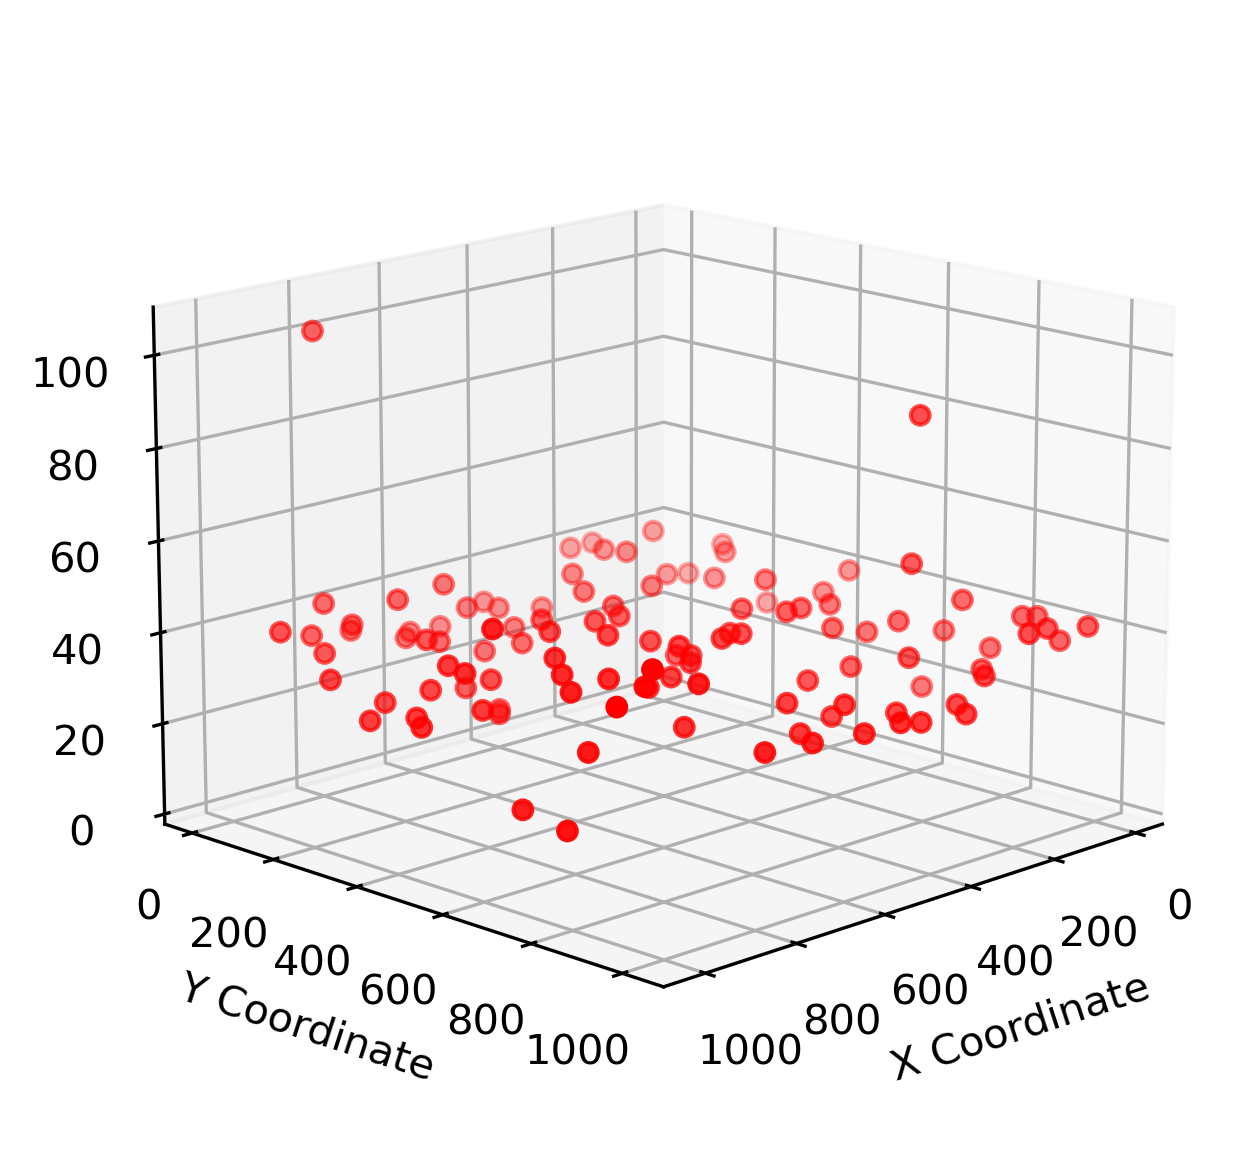

In [5]:
plot_3d_points(coords_3d, (15,45))

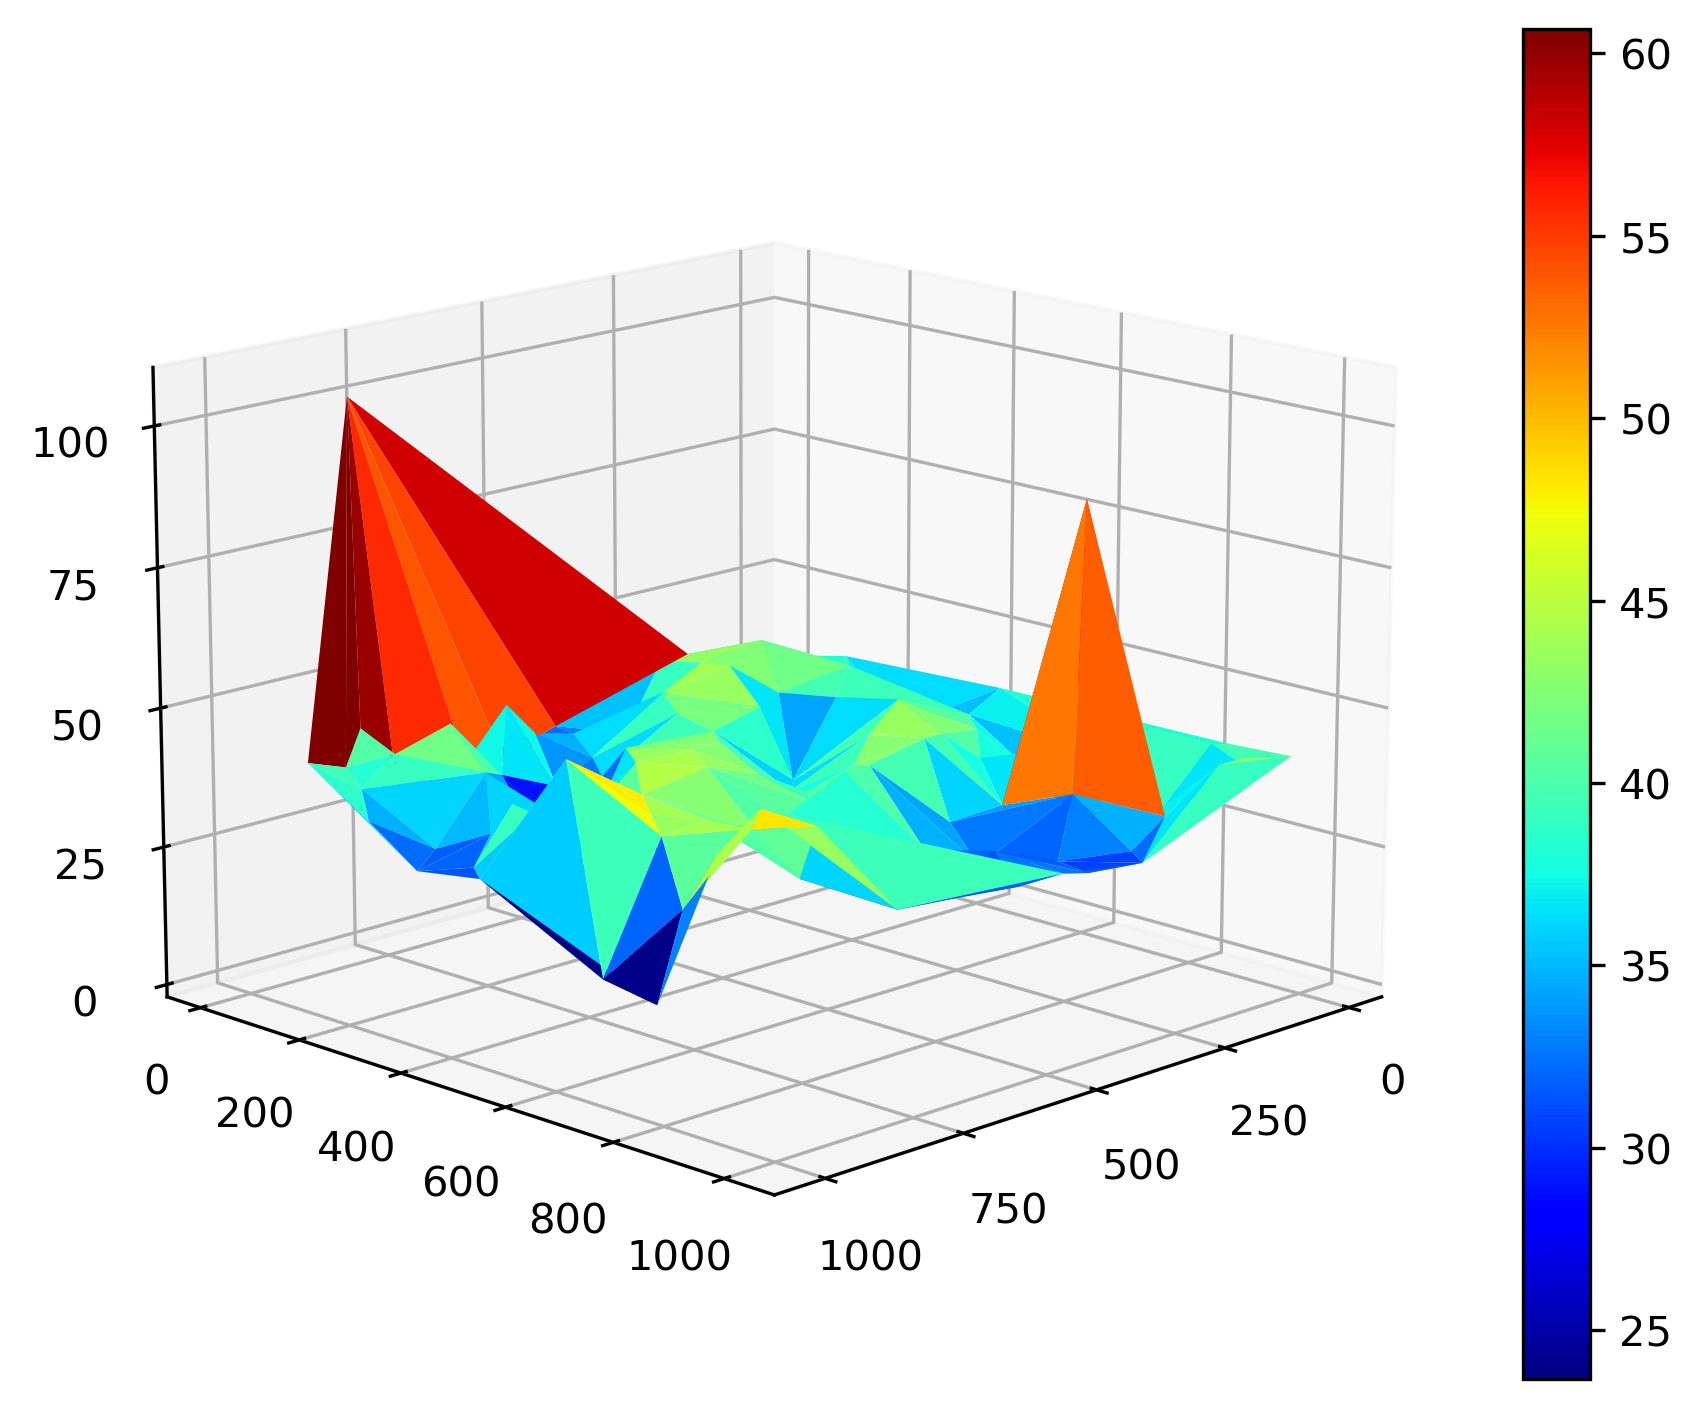

In [6]:
plot_3d_surface(coords_3d, view_angle = (15, 45))

# Visualization of closest points

In [10]:
def mod_plot_3d_points(centers_of_mass, point_index, view_angle=(45, 45)):
    """
    Plots the (x, y, z) coordinates of the centers of mass and highlights the 10 closest points to the given point index.

    :param centers_of_mass: List of tuples containing (x, y, z) coordinates of the centers of mass.
    :param point_index: Index of the reference point to which the 10 closest points will be found.
    :param view_angle: Tuple specifying the (elevation, azimuth) for the view angle.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = np.array([coord[0] for coord in centers_of_mass])
    ys = np.array([coord[1] for coord in centers_of_mass])
    zs = np.array([coord[2] for coord in centers_of_mass])

    # Reference point coordinates
    ref_x = xs[point_index]
    ref_y = ys[point_index]
    ref_z = zs[point_index]

    # Calculate distances from the reference point
    distances = np.sqrt((xs - ref_x)**2 + (ys - ref_y)**2 + (zs - ref_z)**2)

    # Get indices of the 10 closest points
    closest_indices = distances.argsort()[1:16]  # finds closest 15 

    # Indices of points that are not the 10 closest
    other_indices = [i for i in range(len(xs)) if i not in closest_indices and i != point_index]

    # Plot other points in red
    ax.scatter(xs[other_indices], ys[other_indices], zs[other_indices], c='r', marker='o', label='Other Points')

    # Highlight the 10 closest points in blue
    ax.scatter(xs[closest_indices], ys[closest_indices], zs[closest_indices], c='b', marker='o', label='10 Closest Points')

    # Highlight the reference point in green
    ax.scatter(ref_x, ref_y, ref_z, c='g', marker='^', s=100, label='Reference Point')

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_zlim(0, 108)
    ax.view_init(view_angle[0], view_angle[1])
    
    ax.legend()

    plt.show()

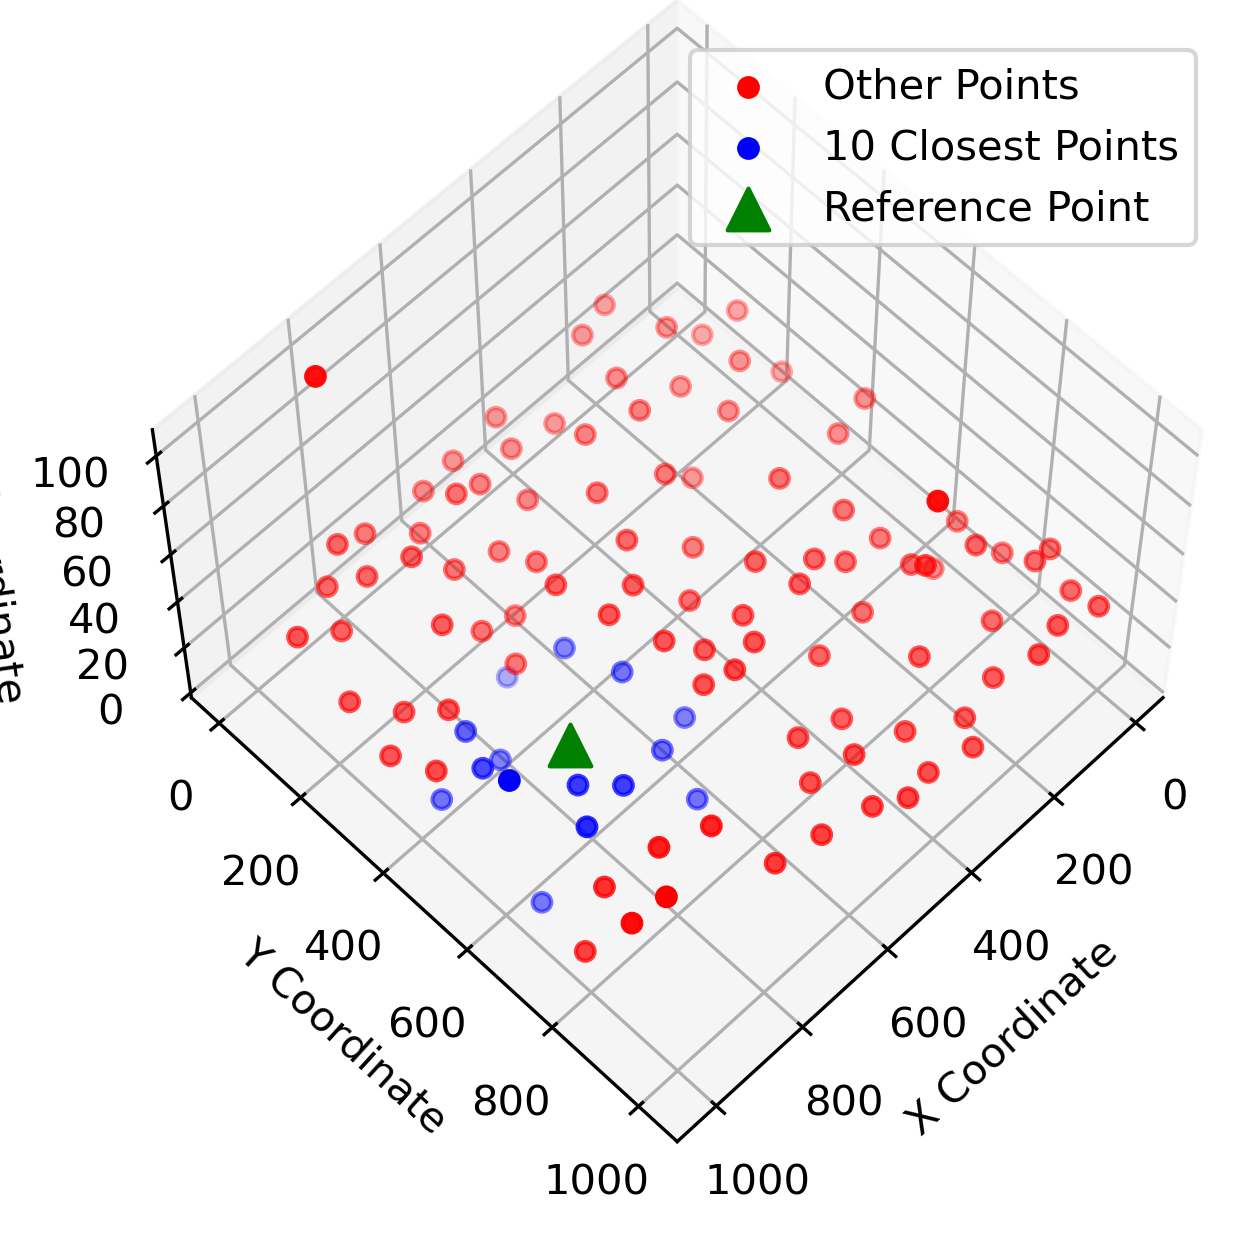

In [22]:
mod_plot_3d_points(coords_3d, 92, (60,45))

# Removing local outliers

In [35]:
def remove_outliers_local(centers_of_mass, num_closest_points=15, z_threshold=2):
    """
    Removes points that are outliers based on the z-values of their closest neighbors.

    :param centers_of_mass: List of tuples containing (x, y, z) coordinates of the centers of mass.
    :param num_closest_points: Number of closest points to consider for outlier detection.
    :param z_threshold: Number of standard deviations from the mean z-value to consider as an outlier.

    :return: Tuple containing filtered list of (x, y, z) coordinates and the indices of the filtered points.
    """
    if num_closest_points >= len(centers_of_mass):
        raise ValueError("num_closest_points must be less than the number of total points")

    filtered_data = []
    filtered_indices = []
    xs = np.array([coord[0] for coord in centers_of_mass])
    ys = np.array([coord[1] for coord in centers_of_mass])
    zs = np.array([coord[2] for coord in centers_of_mass])

    for i, (x, y, z) in enumerate(centers_of_mass):
        # Calculate distances from the current point to all other points
        distances = np.sqrt((xs - x)**2 + (ys - y)**2 + (zs - z)**2)

        # Get indices of the closest points, excluding the point itself
        closest_indices = distances.argsort()[1:num_closest_points+1]

        # Calculate mean and standard deviation of the z-values of these closest points
        z_closest = zs[closest_indices]
        mean_z = np.mean(z_closest)
        std_dev_z = np.std(z_closest)

        # Check if the current point is an outlier in z-value
        if abs(z - mean_z) <= z_threshold * std_dev_z:
            filtered_data.append((x, y, z))
            filtered_indices.append(i)

    return filtered_data, filtered_indices

filtered_coords_3d, filtered_idxs = remove_outliers_local(coords_3d)
filtered_DAPI_masks = extract_masks(DAPI_masks, filtered_idxs)

print('Removed masks:', len(coords_3d) - len(filtered_coords_3d))


Removed masks: 10


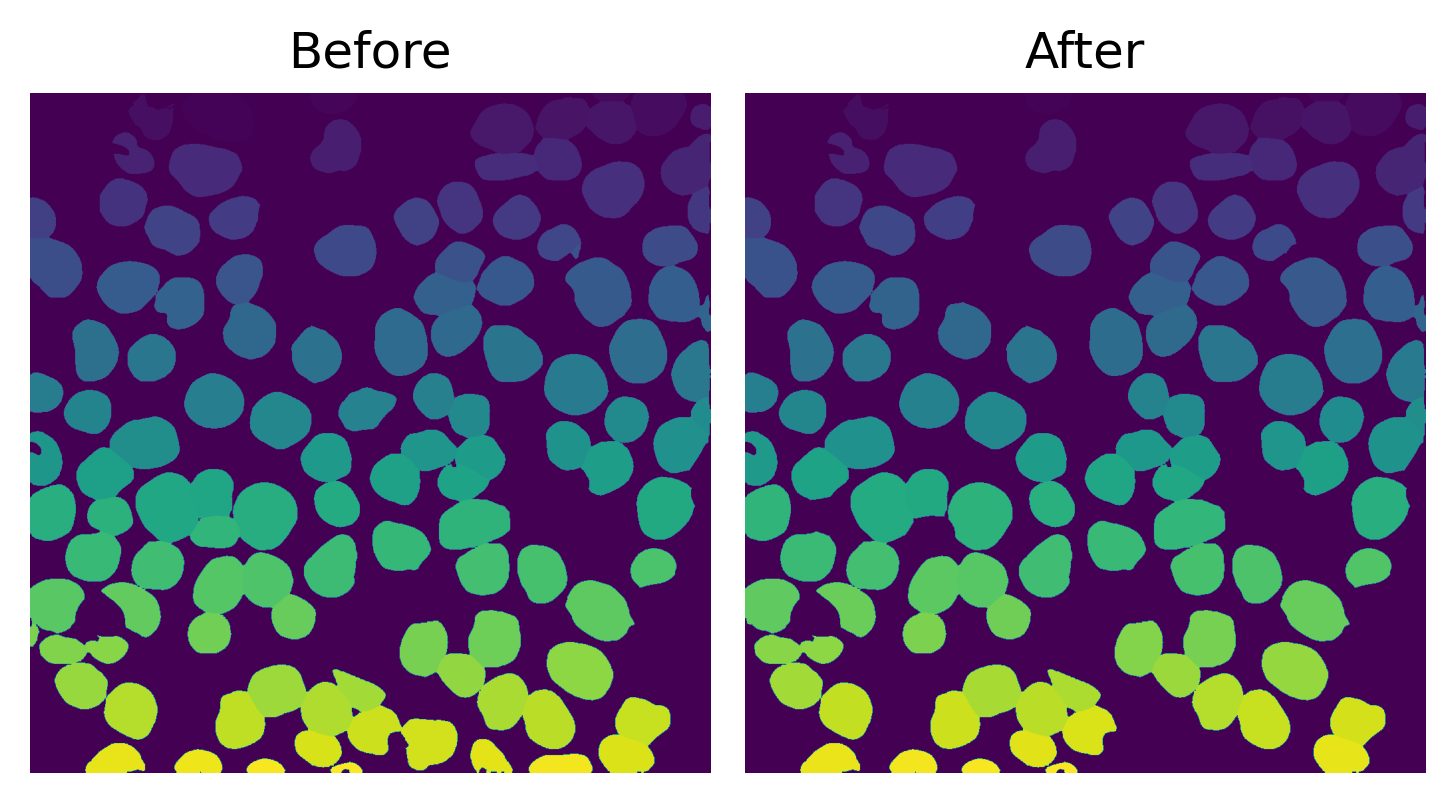

In [36]:
plot_2images(DAPI_masks, filtered_DAPI_masks)

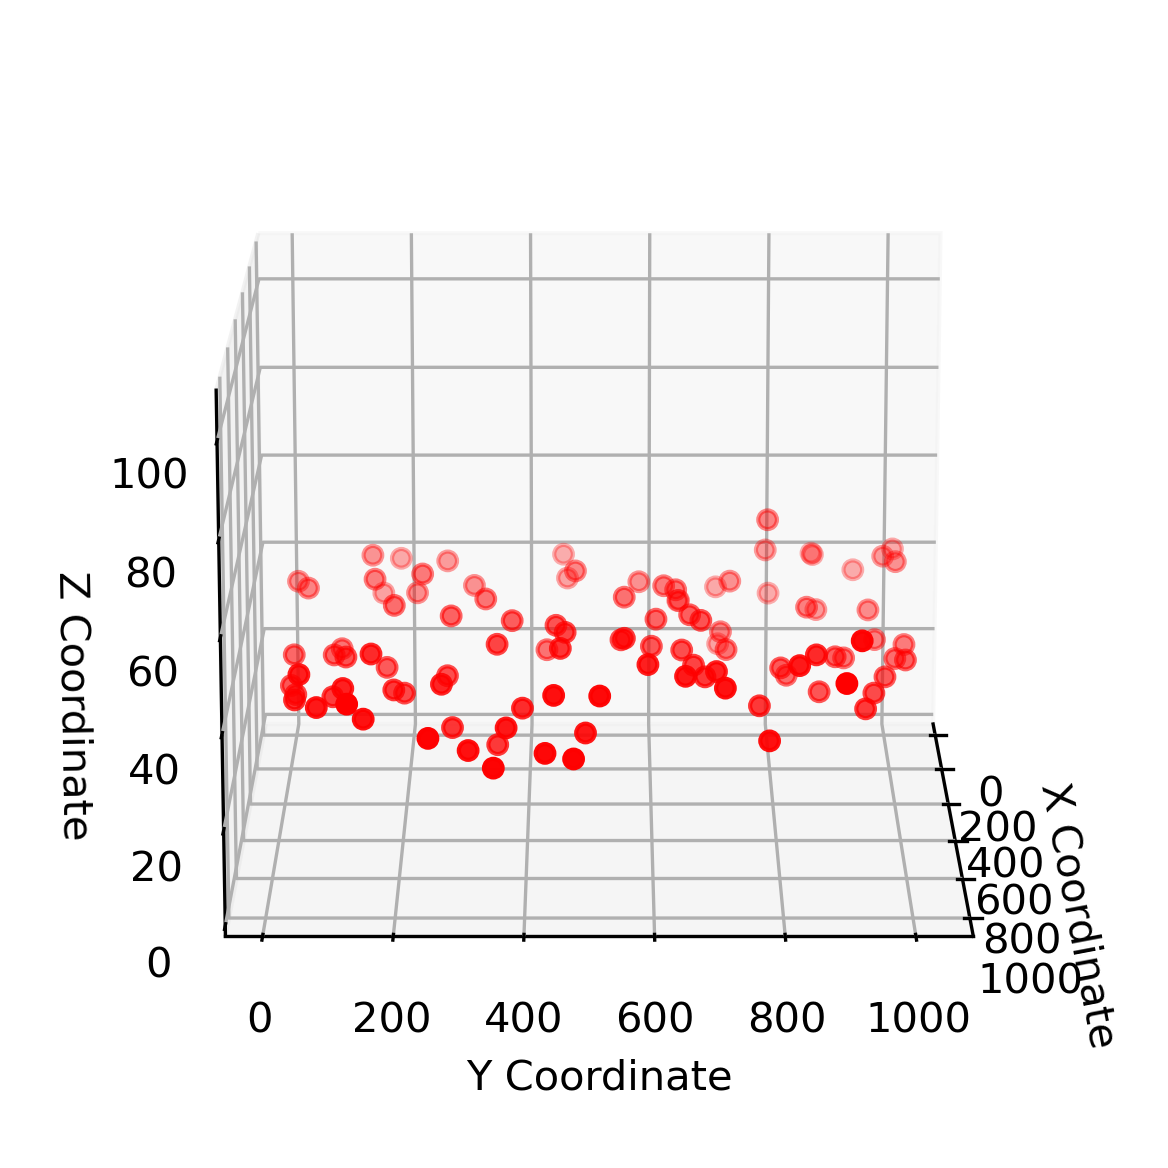

In [48]:
plot_3d_points(filtered_coords_3d, view_angle = (15, 0))

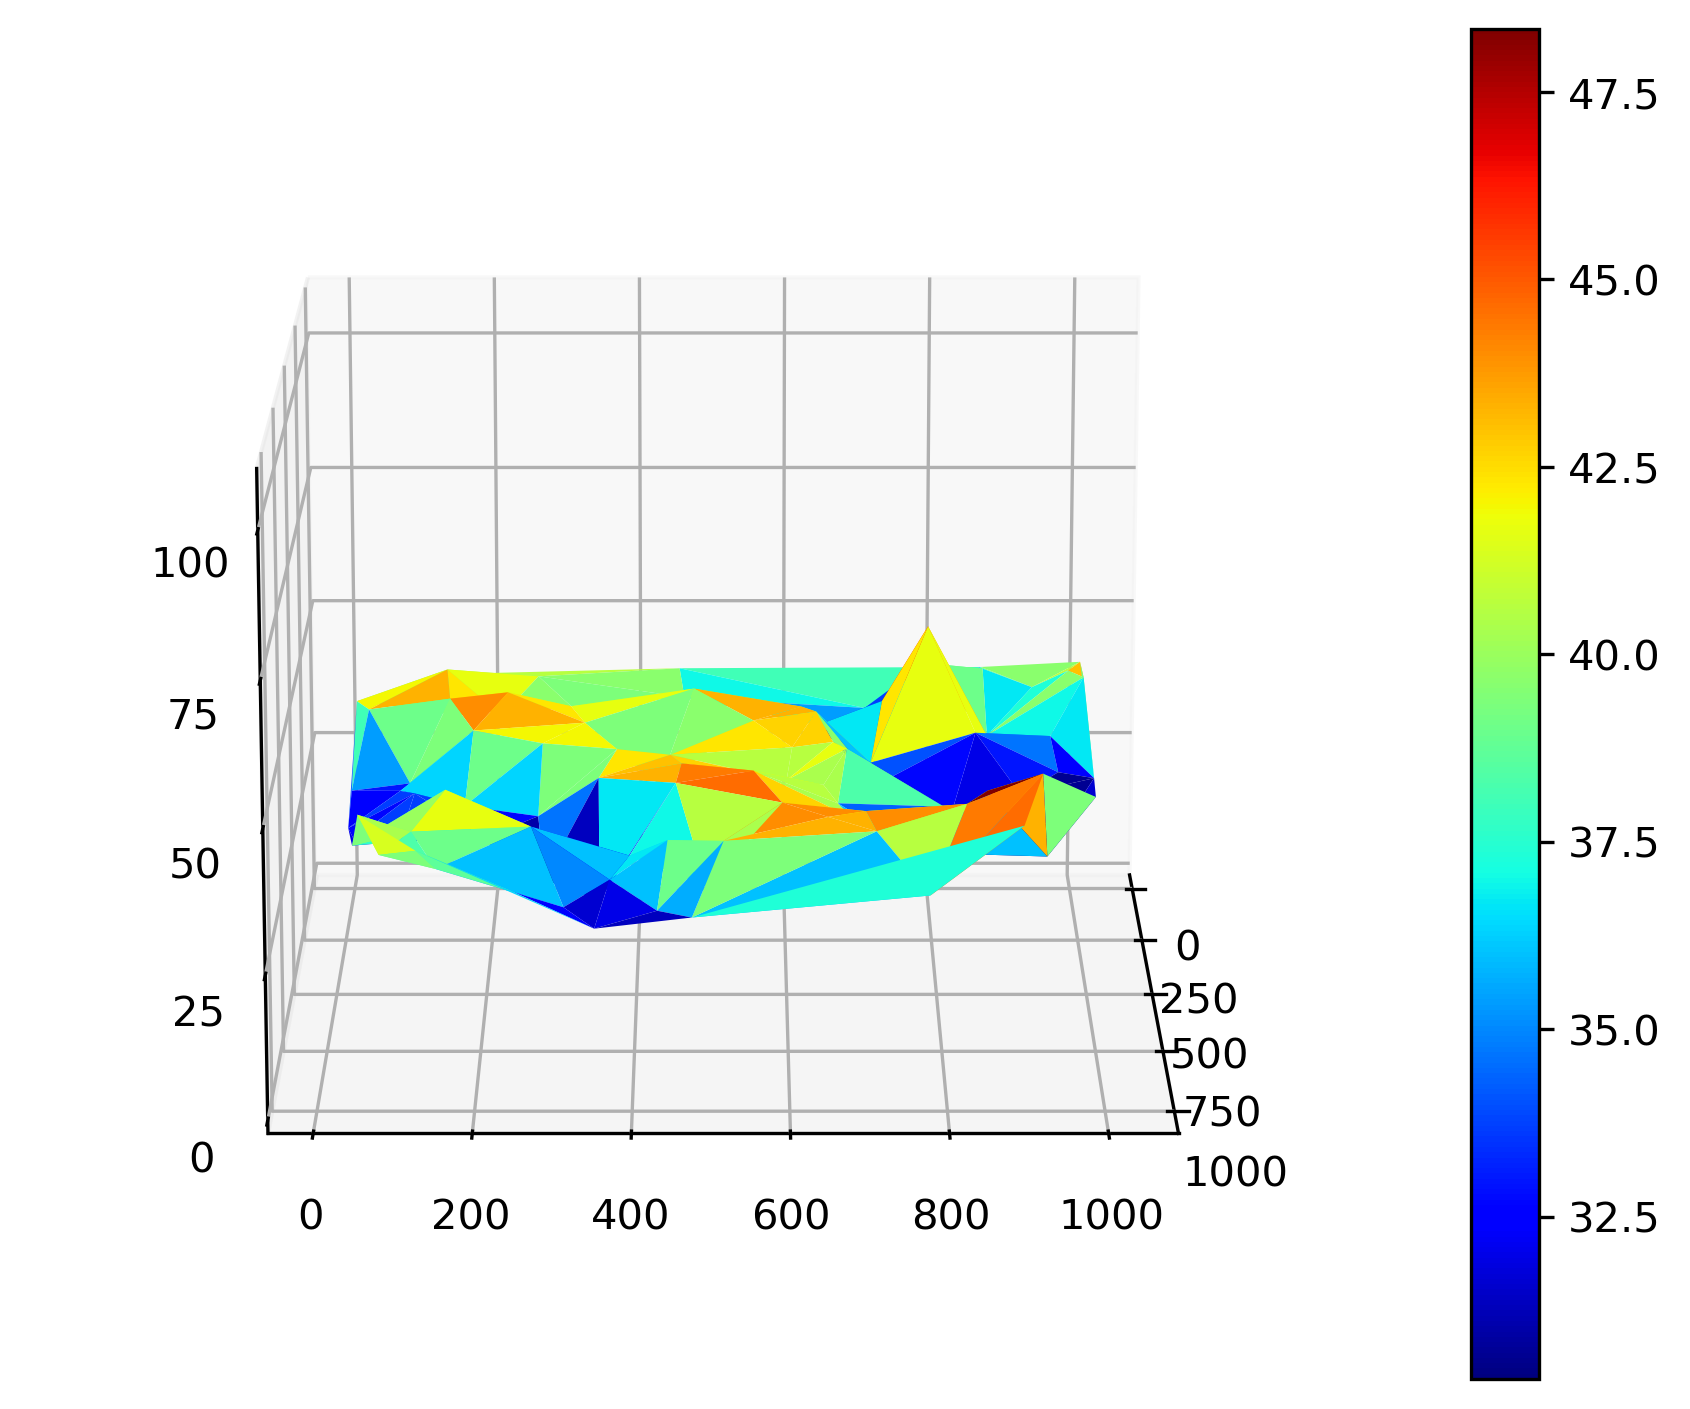

In [52]:
plot_3d_surface(filtered_coords_3d, view_angle= (15, 0))

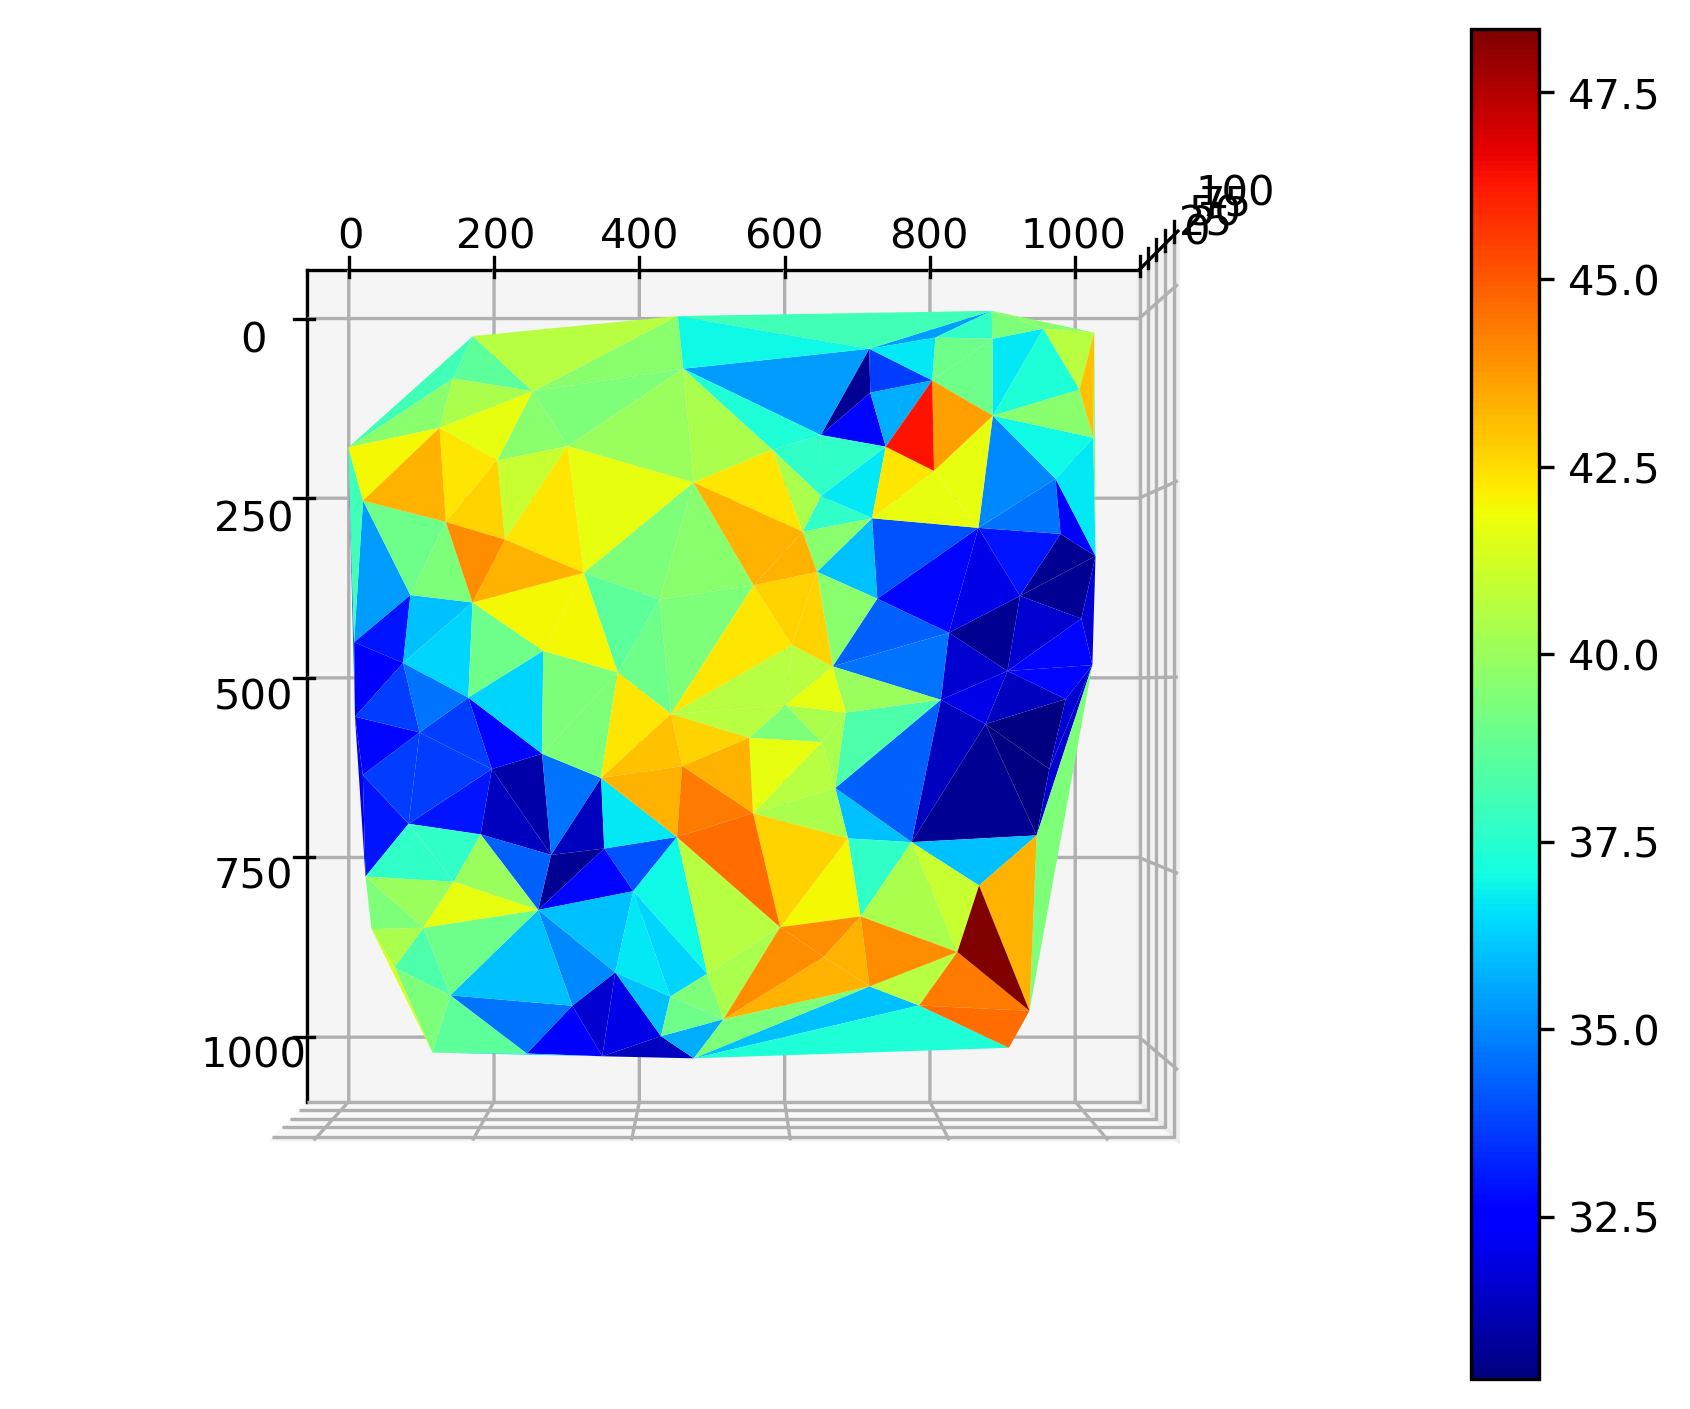

In [50]:
plot_3d_surface(filtered_coords_3d, view_angle= (90,0))

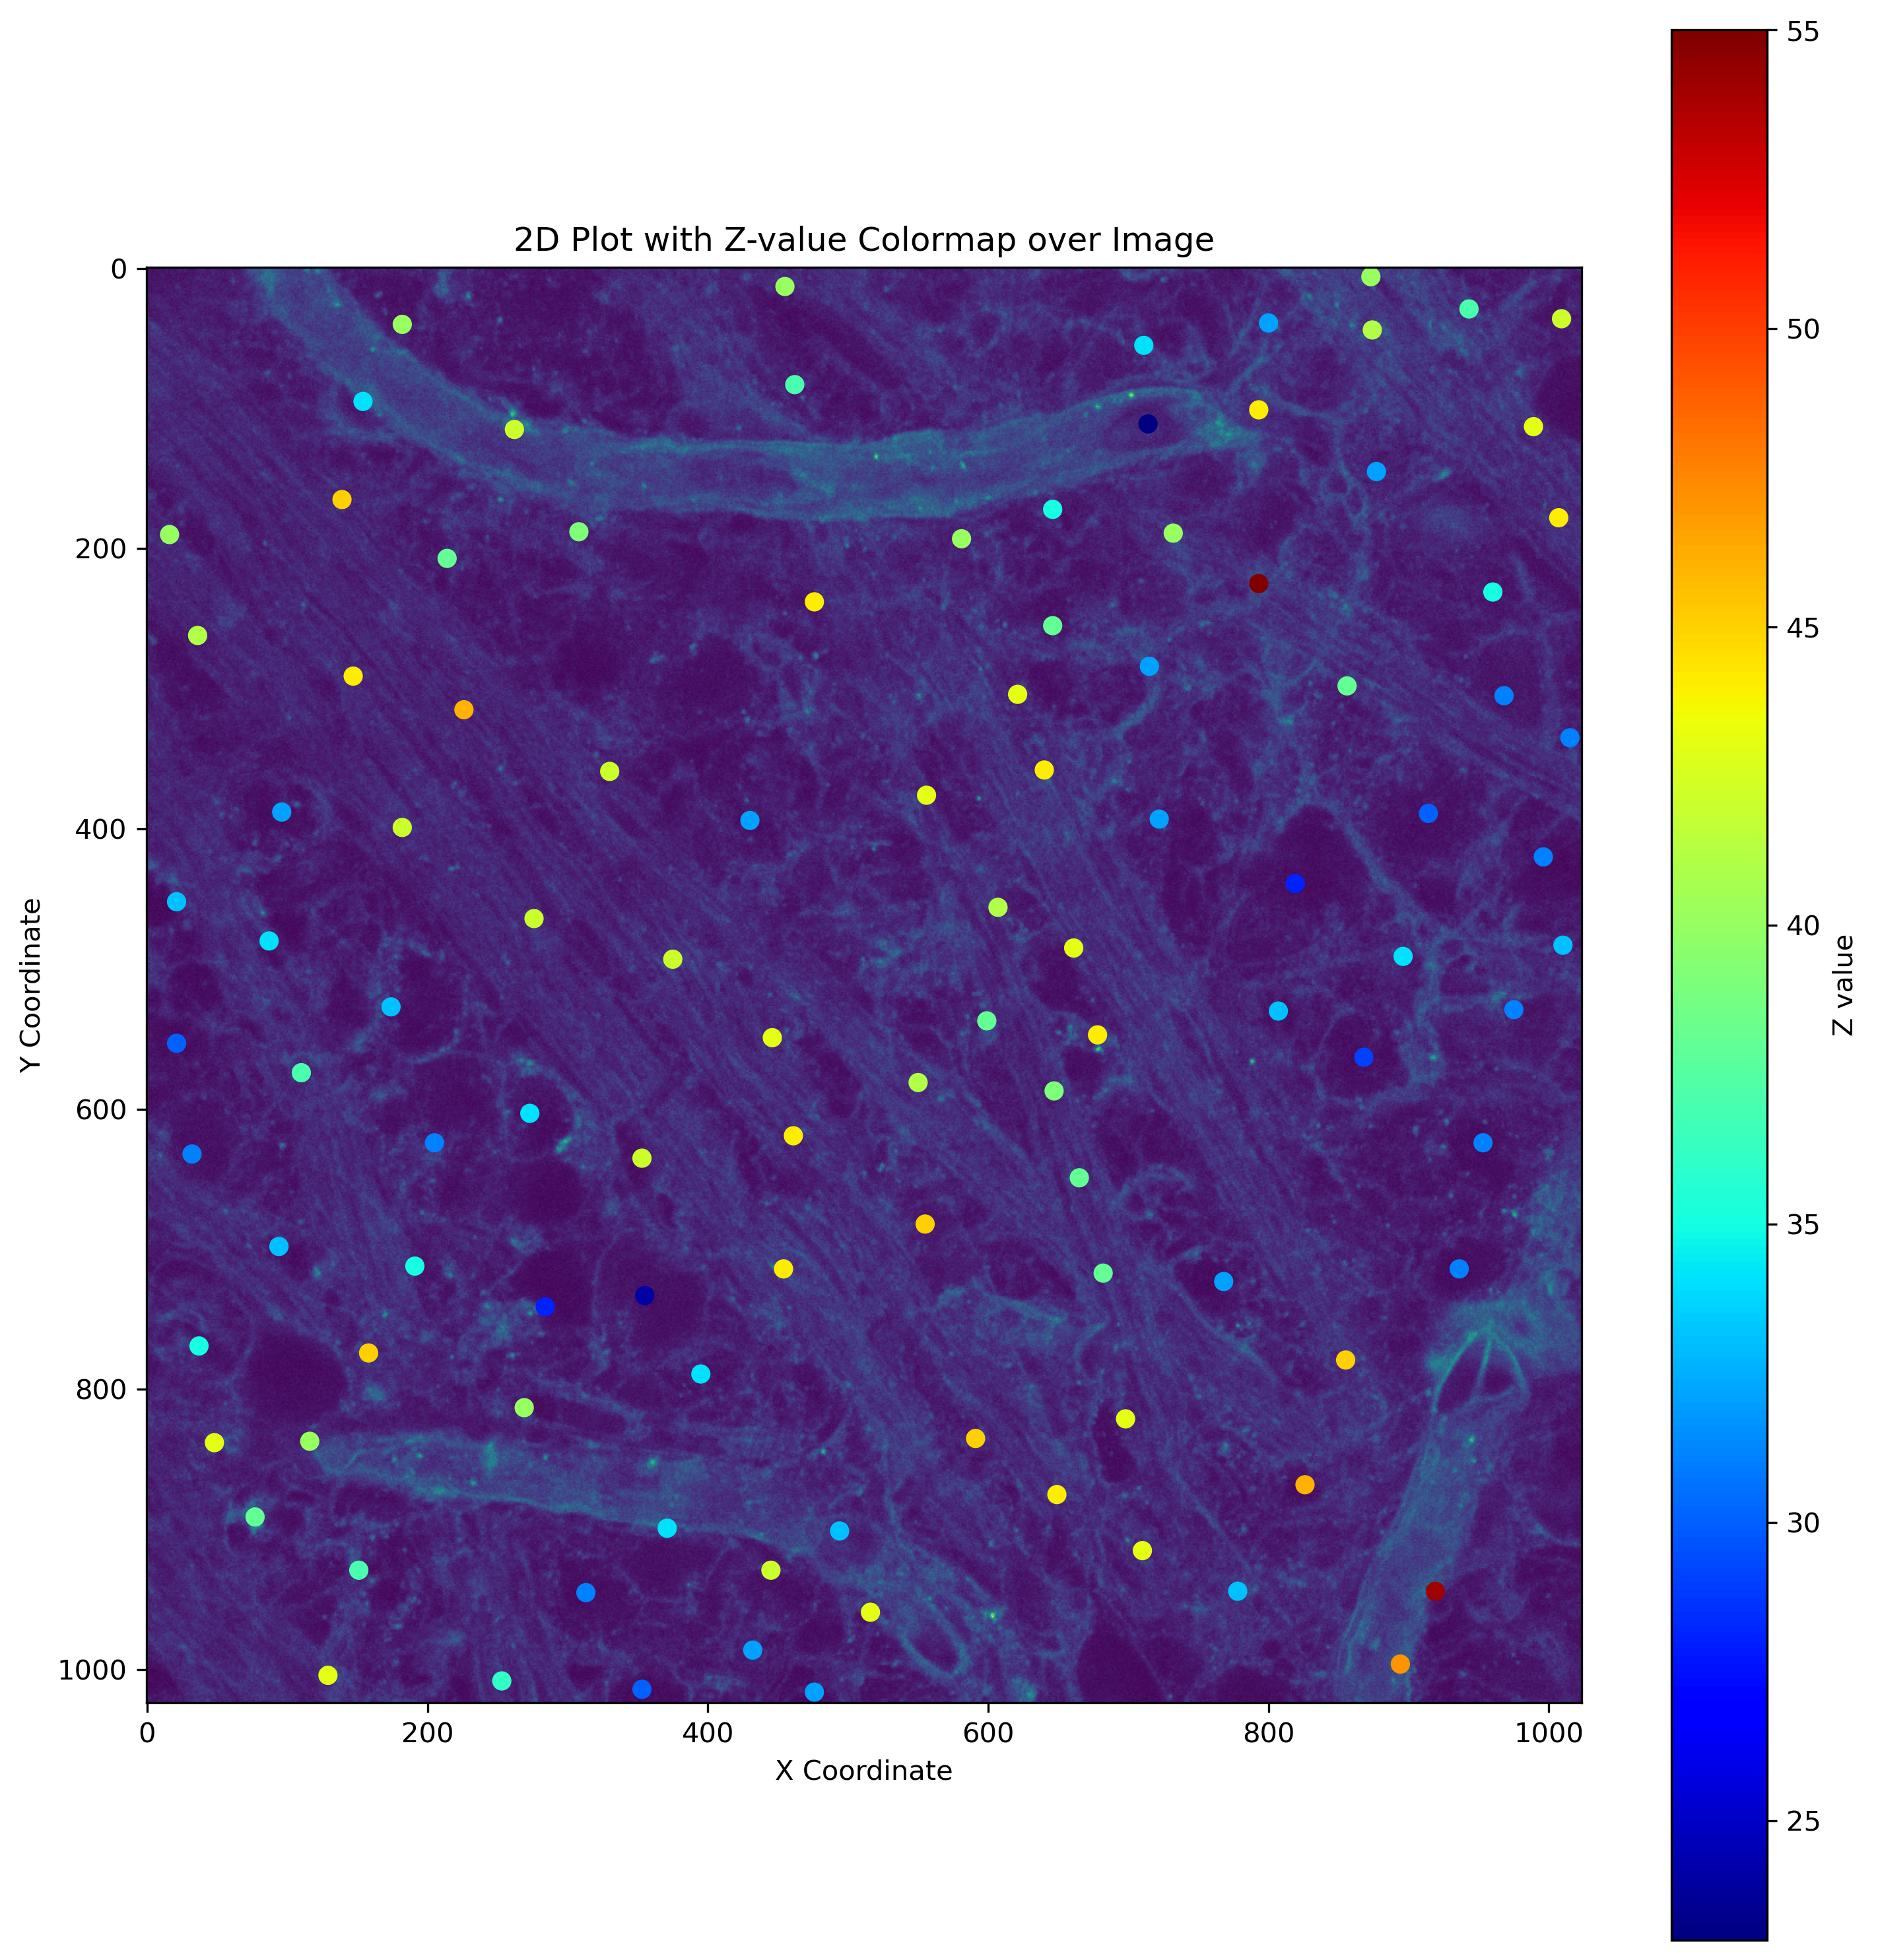

In [19]:
def plot_colormap_over_slice(comp, slice, cmap = cm.jet):
    fig, ax = plt.subplots(figsize=(10, 10))

    ys = np.array([coord[0] for coord in comp])
    xs = np.array([coord[1] for coord in comp])
    zs = np.array([coord[2] for coord in comp])

    # Determine the min and max of the z-values
    z_min, z_max = zs.min(), zs.max()

    # Plot the specified layer from WGA_stack as the background
    ax.imshow(slice)
    
    # Create scatter plot over the image
    scatter = ax.scatter(xs, ys, c=zs, cmap=cmap, vmin=z_min, vmax=z_max)
    fig.colorbar(scatter, ax=ax, label='Z value')


    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('2D Plot with Z-value Colormap over Image')

    plt.tight_layout()
    plt.show()


nuclei_zs = nuclei_slices(DAPI_stack, DAPI_masks)
z_intensities = np.sum(WGA_stack, axis=(1, 2))
ILM_layer = int(np.argmax(z_intensities)) / 2
nuclei_layer = np.sum(nuclei_zs) // len(nuclei_zs)
vein_axon_layer = int((ILM_layer + nuclei_layer) / 2)

slice = WGA_stack[vein_axon_layer, :, :]
plot_colormap_over_slice(filtered_coords_3d, slice)
